# Gaussian Process

src: https://www.ritchievink.com/blog/2019/02/01/an-intuitive-introduction-to-gaussian-processes/


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image

## Multivariate Gaussian Distribution
Gaussian distribution with $\mu=[0,0]$ and $\Sigma=[[1,.6], [.6, 1]]$

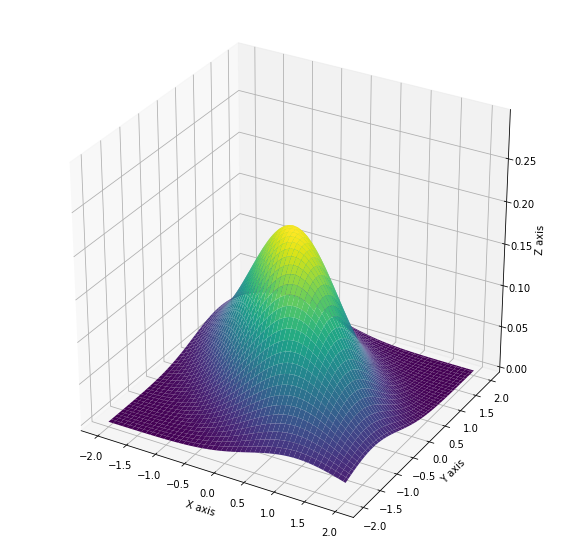

In [3]:
Image(filename='figs/mvgs.png', width=400)

### Marginal Gaussian: Gaussians make baby Gaussians
- Any marginal density of Gaussian is Gaussian
- Given
$$
    p(x,y) = \mathcal{N} (\mu=[\mu_x, \mu_y], \Sigma=[[s_x, s_{xy}], [s_{xy}, s_y]])
$$
$$
p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, s_x)
$$

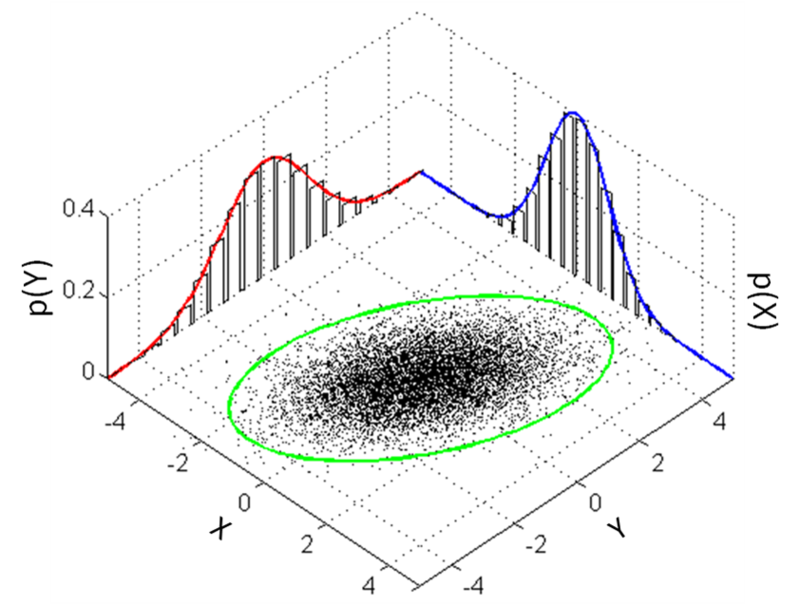

In [4]:
Image(filename='figs/marginal.png', width=500)

### Conditional Probability
$$
    p(x|y=y_0) = \mathcal{N}\big(\mu_x + s_{xy} s_y^{-1} (y_0 - \mu_y),  s_x - s_{xy} s_y^{-1} s_{xy}^T\big)
$$
- conditional mean: $\mu_{x|y=y_0} = \mu_x + s_{xy} s_y^{-1} (y_0 - \mu_y)$
- conditional covariance: $s_{x|y=y_0} = s_x - s_{xy} s_y^{-1} s_{xy}^T$

Below is a plot of $p(x_2|x_1=1)$, which shows how the conditional distribution also leads to a Gaussian distribution (red color).

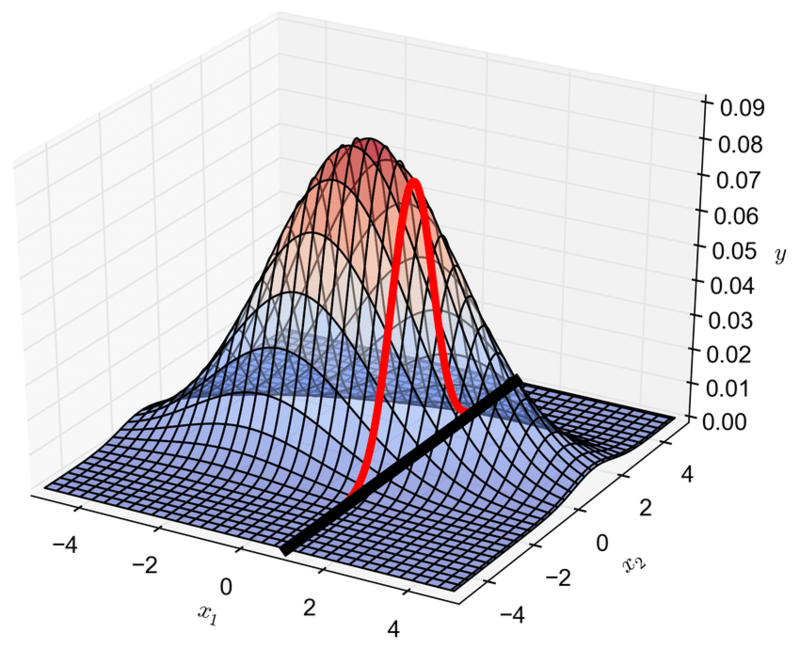

In [5]:
Image(filename='figs/cond.png', width=500)

## Functions described as multivariate Gaussians

- A function: $f: x \rightarrow y$, $f(x) = y$
- We define a multivariate Gaussian for all possible values of $f(x)$, $x \in X$:
$$
    \begin{pmatrix}
    f(x_1) & ... &f(x_n)
    \end{pmatrix} ^T
    =
    \mathcal{N}\bigg(
        \begin{pmatrix}
            \mu & ... & \mu
        \end{pmatrix} ^T
        ,
        \begin{pmatrix}
            \sigma_{11} & ... & \sigma_{1n} \\
            \vdots & \vdots & \vdots \\
            \sigma_{n1} & ... & \sigma_{nn} \\
        \end{pmatrix} ^T
    \bigg)
$$
    - $\mu_i$ is the expected value of $f(x_i)$.
    - The size $n$ is not fixed and can be considered for every $x$.

Below is an example. In total we have $n=50$ points from a sample of Gaussian, and the outputs are connected with line segments.
- The mean vector is given by a sin function
- the covariance is almost zero. So the random draw is almost fixed and deterministic.

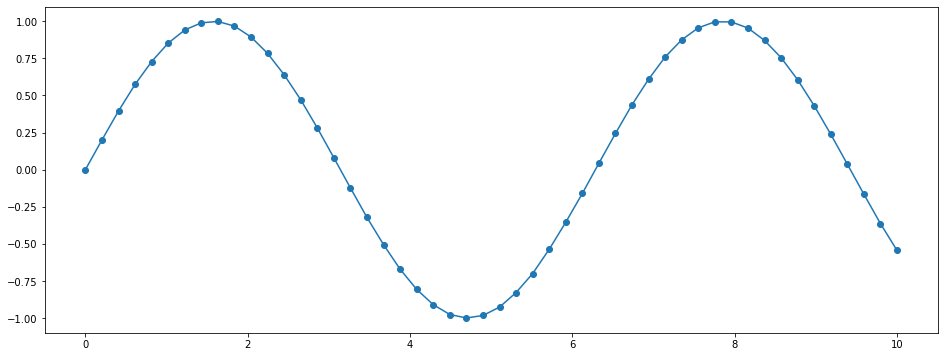

In [11]:
n = 50
x = np.linspace(0, 10, n)

# Define the gaussian with mu = sin(x) and negligible covariance matrix
norm = stats.multivariate_normal(mean=np.sin(x), cov=np.eye(n) * 1e-6)
plt.figure(figsize=(16, 6))

# Taking a sample from the distribution and plotting it.
plt.plot(x, norm.rvs(), 'o-');

- Now the covariance is not zero.
- multiple draws from the same normal distribution. Due to a large covariance, some variation appear.
- the covariance matrix is diagonal, which means $f_i$ and $f_j$ are mutually **independent**.

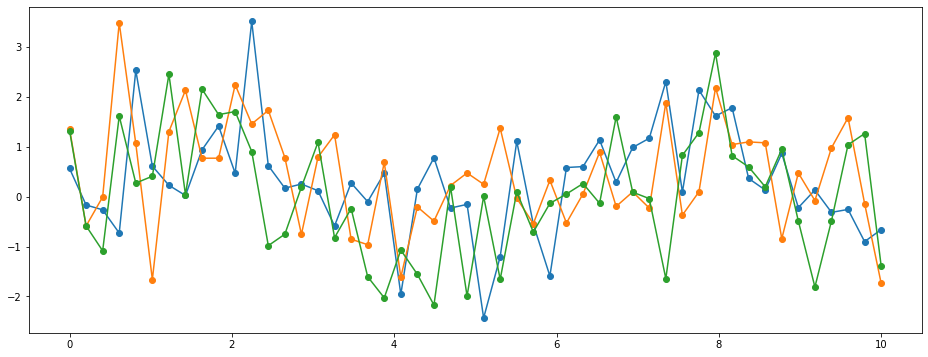

In [24]:
norm = stats.multivariate_normal(mean=np.sin(x), cov=np.eye(n) )

plt.figure(figsize=(16, 6))
# Taking a sample from the distribution and plotting it.
[ plt.plot(x, norm.rvs(), 'o-') for _ in range(3) ];

- the mean vector $[\mu_i]$ is zeros below with the same covariance.

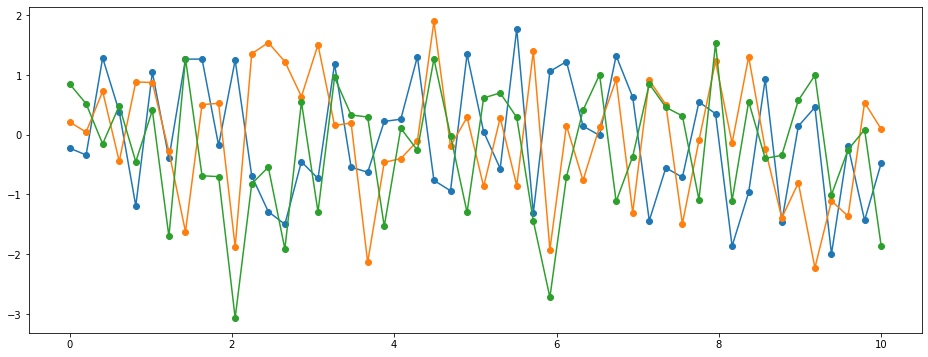

In [25]:
norm = stats.multivariate_normal(mean=np.zeros(n), cov=np.eye(n) )

plt.figure(figsize=(16, 6))
# Taking a sample from the distribution and plotting it.
[ plt.plot(x, norm.rvs(), 'o-') for _ in range(3) ];

## Controlling the functions with kernels
- We want a relation (correlation) between $f_i$ and $f_j$. For example, we may want to draw samples from a smooth function.
- We can do it by setting the covariance matrix $\Sigma$.

### Squared exponential kernel
- Here, kernel means covariance matrix as a function of $x$ (or $x_i$ and $x_j$)
$$
    k(x, x') = \exp\bigg({-\frac{(x-x')^2}{2l^2}}\bigg)
$$

In [74]:
def kernel(x, xp, l=.1):
    # the kernel may found to be almost singuar. Don't worry about it now.
    # One 
    return np.exp( - (x.reshape(-1,1) - xp)**2 / (2*l*l))
    
cov=kernel(x, x, l=.44)
print(cov[:3, :3])

[[1.         0.89801781 0.65033901]
 [0.89801781 1.         0.89801781]
 [0.65033901 0.89801781 1.        ]]


In [75]:
np.linalg.eigvals(cov)

array([5.35965949e+00, 5.22797806e+00, 5.01569889e+00, 4.73298858e+00,
       4.39291681e+00, 4.01045183e+00, 3.60137005e+00, 3.18119013e+00,
       2.76423005e+00, 2.36286267e+00, 1.98701542e+00, 1.64392723e+00,
       1.33814688e+00, 1.07173347e+00, 8.44605277e-01, 6.54977788e-01,
       4.99834076e-01, 3.75379471e-01, 2.77444862e-01, 2.01816591e-01,
       1.44483733e-01, 1.01804096e-01, 7.05978455e-02, 4.81820869e-02,
       3.23613855e-02, 2.13887573e-02, 1.39097594e-02, 8.89970820e-03,
       5.60127419e-03, 3.46713182e-03, 2.11021466e-03, 1.26251454e-03,
       7.42263113e-04, 4.28670278e-04, 2.43071872e-04, 1.35256347e-04,
       7.38099120e-05, 3.94707630e-05, 2.06654334e-05, 1.05814118e-05,
       5.29161960e-06, 2.58021135e-06, 1.22413534e-06, 5.63547587e-07,
       2.50836281e-07, 1.07411553e-07, 4.39371491e-08, 1.69943893e-08,
       6.14829999e-09, 2.16035355e-09])

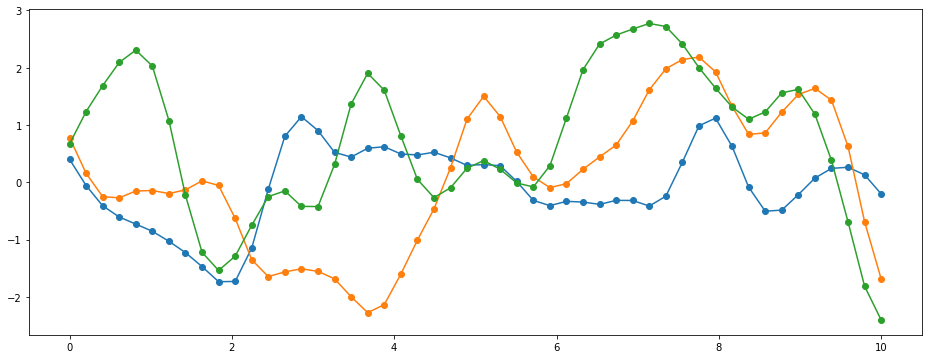

In [82]:
norm = stats.multivariate_normal(mean=np.zeros(n), cov=cov)
plt.figure(figsize=(16,6))
[plt.plot(x, norm.rvs(), 'o-') for _ in range(3)];